In [29]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from mltrainer import Trainer
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import math

import sys

sys.path.append("../")
from src import datasets, metrics
import mltrainer

mltrainer.__version__

'0.1.128'

In [30]:
trainfile = Path("../data/heart_train.parq").resolve()
testfile = Path("../data/heart_test.parq").resolve()
# trainfile = Path('../data/heart_big_train.parq').resolve()
# testfile = Path('../data/heart_big_test.parq').resolve()

In [31]:
traindataset = datasets.HeartDataset1D(trainfile, target="target")
testdataset = datasets.HeartDataset1D(testfile, target="target")
traindataset, testdataset

# moving to mps device crashes the jypyter kernel, not sure why

(Heartdataset (len 11641), Heartdataset (len 2911))

In [32]:
trainstreamer = BaseDatastreamer(
    traindataset, preprocessor=BasePreprocessor(), batchsize=32
)
teststreamer = BaseDatastreamer(
    testdataset, preprocessor=BasePreprocessor(), batchsize=32
)
len(trainstreamer), len(teststreamer)

(363, 90)

In [33]:
class GRUBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout):
        super(GRUBlock, self).__init__()
        self.gru = nn.GRU(
            input_size=hidden_size,
            hidden_size=hidden_size,
            batch_first=True,
        )
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size, num_heads=num_heads, batch_first=True
        )
        self.ff = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size),
        )
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)
        self.layer_norm3 = nn.LayerNorm(hidden_size)

    def forward(self, x):
        identity = x.clone()  # skip connection
        x, _ = self.gru(x)
        x = self.layer_norm1(x + identity)  # Add & Norm skip

        identity = x.clone()  # second skip connection
        x, _ = self.attention(x, x, x)  # Apply attention
        x = self.layer_norm2(x + identity)  # Add & Norm skip

        identity = x.clone()  # third skip connection
        x = self.ff(x)
        x = self.layer_norm3(x + identity)  # Add & Norm skip
        return x


class GRUModel(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()
        self.conv1d = nn.Conv1d(
            in_channels=1,
            out_channels=config["hidden"],
            kernel_size=3,
            stride=2,
            padding=1,
        )

        # Create multiple GRU blocks
        self.gru_blocks = nn.ModuleList(
            [
                GRUBlock(config["hidden"], config["num_heads"], config["dropout"])
                for _ in range(config["num_blocks"])
            ]
        )

        self.out = nn.Linear(config["hidden"], config["output"])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # streamer: (batch, seq_len, channels)
        # conv1d:   (batch, channels, seq_len)
        # gru:      (batch, seq_len, channels)
        x = self.conv1d(x.transpose(1, 2))  # flip channels and seq_len for conv1d
        x = x.transpose(1, 2)  # flip back to seq_len and channels

        # Apply multiple GRU blocks
        for gru_block in self.gru_blocks:
            x = gru_block(x)

        x = x.mean(dim=1)  # Global Average Pooling
        x = self.out(x)
        return x

In [34]:
from src import models

config = {"hidden": 128, "dropout": 0.2, "output": 2, "num_heads": 4, "num_blocks": 5}
model = models.GRUModel(config)

In [35]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 192, 1]), torch.Size([32]))

In [36]:
yhat = model(x)
yhat.shape

torch.Size([32, 2])

In [37]:
f1micro = metrics.F1Score(average="micro")
f1macro = metrics.F1Score(average="macro")
precision = metrics.Precision("micro")
recall = metrics.Recall("macro")
accuracy = metrics.Accuracy()

In [38]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("Gru_Attention")

<Experiment: artifact_location='/home/azureuser/code/mads-exam-24/notebooks/mlruns/5', creation_time=1719408284529, experiment_id='5', last_update_time=1719408284529, lifecycle_stage='active', name='Gru_Attention', tags={}>

In [39]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
import torch.optim as optim

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam
scheduler = optim.lr_scheduler.ReduceLROnPlateau

with mlflow.start_run():

    settings = TrainerSettings(
        epochs=10,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="heart1D",
        train_steps=len(trainstreamer),
        valid_steps=len(teststreamer),
        reporttypes=[ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs=None,
    )

    mlflow.set_tag("model", "Gru_Attention")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "Reduce on Plateau")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=optim.lr_scheduler.ReduceLROnPlateau,
    )
    trainer.loop()

2024-06-29 13:22:40.100 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to heart1D/20240629-132240
100%|██████████| 363/363 [05:23<00:00,  1.12it/s]
2024-06-29 13:28:32.741 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.5513 test 0.4569 metric ['0.7399', '0.7399', '0.6847', '0.7399', '0.7082']
100%|██████████| 363/363 [05:39<00:00,  1.07it/s]
2024-06-29 13:34:28.206 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.3944 test 0.3474 metric ['0.8493', '0.8493', '0.7956', '0.8493', '0.7924']
100%|██████████| 363/363 [05:22<00:00,  1.13it/s]
2024-06-29 13:40:25.985 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2664 test 0.3642 metric ['0.8406', '0.8406', '0.8188', '0.8406', '0.8782']
100%|██████████| 363/363 [04:31<00:00,  1.34it/s]
2024-06-29 13:45:29.397 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1941 test 0.1802 metric ['0.9413', '0.9413', '0.9206', '0.9413', '0.9131']
100%|██████████| 363/363 [34:46<00:00,  5.75s/it]
2

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

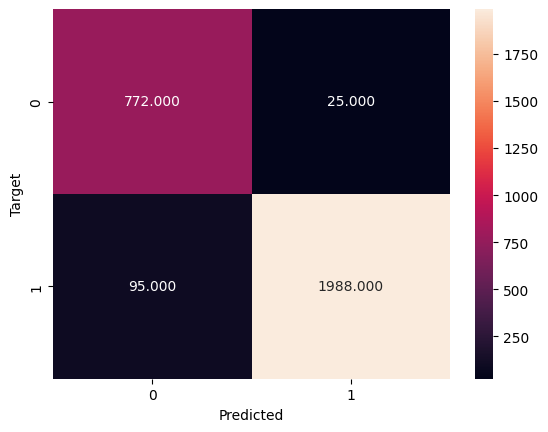

In [40]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1)  # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
# cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

In [41]:
# Haal de TP en FN waarden uit de confusion matrix
TP = cfm[1, 1]  # True Positives
FN = cfm[1, 0]  # False Negatives

# Bereken de Recall
recall = TP / (TP + FN)
print(f"Recall: {recall:.3f}")

Recall: 0.954
